In [1]:
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely import box
import pandas as pd
from scientific_python_utils.geospatial import ensure_projected_CRS
from scientific_python_utils.geometric import merge_classified_polygons, ensure_non_overlapping_polygons
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
METADATA_FILE = Path("/ofo-share/drone-imagery-organization/3c_metadata-extracted/all-mission-polygons-w-metadata.gpkg")
PREDS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/final/post_processed_shifted_predictions")

ENSURE_NONOVERLAPPING = True
#Quail, BORR, Hastings
RESERVE = "BORR"
ONLY_LEAF_ON = True

CLASS_NAMES = ["Bare Earth", "Herbaceous Live", "Man Made", "Shrub Dead", "Shrub Live", "Tree Dead", "Tree Live", "Water"]

# Start and end date as month and year (mmdd)
LEAF_ON_START_DATE = 415
LEAF_ON_END_DATE = 1100

<Axes: >

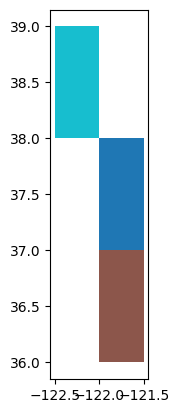

In [3]:
# The generous bounds of the reserves
reserve_bounds = gpd.GeoDataFrame(
    {
        "geometry":
            [
                box(xmin=-122.5, ymin=38, xmax=-122, ymax=39),
                box(xmin=-122, ymin=37, xmax=-121.5, ymax=38),
                box(xmin=-122, ymin=36, xmax=-121.5, ymax=37)
            ],
        "reserve": ["Quail", "BORR", "Hastings"]
    },
    crs=4326
)
reserve_bounds.plot("reserve")

In [4]:
def plot_map(gdf, title=None):
    ax = gdf.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5, legend=True, categorical=False)
    if title is not None:
        ax.set_title(title)

In [5]:
def compute_standardized(preds, shared_region, reserve, year, ensure_nonoverlapping=False):
    if len(preds) == 0:
        return None

    if ensure_nonoverlapping:
        #print("About to clip")
        dissolved = preds.dissolve(by="class_names", as_index=False)
        subset = dissolved.clip(shared_region)
        #subset = preds.clip(shared_region)
        #print("About to merge")
        #subset = merge_classified_polygons(subset, class_column="class_names", print_tiebreaking_stats=True)
        #print("Done merging")
    else:
        # Merge all instances of the same class across all predicted datasets
        dissolved = preds.dissolve(by="class_names", as_index=False)
        plot_map(dissolved, title=f"{year}: before clipping")

        subset = dissolved.clip(shared_region)

    plot_map(subset, title=f"{year}: after clipping")
    plt.savefig(Path(f"../data/vis/final_cover_{reserve}_{year}.png"))

    subset = ensure_projected_CRS(subset)
    # Clean up the geometry
    subset.geometry = subset.buffer(0)
    # Compute the area fraction
    total_area = gpd.GeoDataFrame(data={"geometry": shared_region}, crs=4326).to_crs(subset.crs).area.values[0]

    subset["area_fraction"] = subset.area / total_area
    subset.to_file(Path(f"../data/vis/final_cover_{reserve}_{year}.gpkg"))

    return subset

def compute_transition_matrix(first_class_df, second_class_df, reserve):
    overlay = first_class_df.overlay(second_class_df)

    # Get the classes for the left and right dataframes
    i_inds = overlay["class_ID_1"].to_numpy().astype(int)
    j_inds = overlay["class_ID_2"].to_numpy().astype(int)
    # Get the areas of the overlaps
    values = overlay.area.to_numpy()

    # Build a matrix to populate
    transition_matrix = np.zeros((8,8))
    transition_matrix[i_inds, j_inds] = values
    transition_matrix_row_normed = transition_matrix / np.expand_dims(transition_matrix.sum(axis=1), axis=1)

    # Compute the years from the dataframes
    first_year = first_class_df["earliest_datetime_local_derived"].dt.strftime('%Y').astype(int)[0]
    second_year = second_class_df["earliest_datetime_local_derived"].dt.strftime('%Y').astype(int)[0]


    # Display the results
    ConfusionMatrixDisplay(
        transition_matrix,
        display_labels=CLASS_NAMES
    ).plot()
    plt.title(f"Transition matrix for {reserve} for {first_year}-{second_year}")
    plt.xticks(rotation=70)
    plt.savefig(Path(f"../data/vis/transition_{reserve}_{first_year}_{second_year}.png"))
    plt.show()
    # Show the results with each row normalized to a sum of one
    ConfusionMatrixDisplay(
        transition_matrix_row_normed,
        display_labels=CLASS_NAMES
    ).plot()
    plt.title(f"Transition matrix (row-normalized) for {reserve} for {first_year}-{second_year}")
    plt.xticks(rotation=70)
    plt.savefig(Path(f"../data/vis/transition_normalized_{reserve}_{first_year}_{second_year}.png"))
    plt.show()

In [6]:
metadata = gpd.read_file(METADATA_FILE)
metadata = metadata[["mission_id", "earliest_datetime_local_derived"]]

In [7]:
pred_files = sorted(PREDS_FOLDER.glob("*"))

# Load predictions

<Axes: >

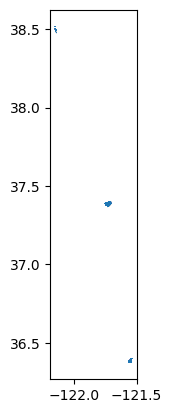

In [8]:
preds = []

for pred_file in pred_files:
    pred = gpd.read_file(pred_file)
    pred["mission_id"] = pred_file.stem
    # Something is weird with this dataset and it's a collection of individual polygons
    if pred_file.stem == "000559":
        pred = pred.dissolve("class_names", as_index=False)

    preds.append(pred)

all_preds = pd.concat(preds)
all_preds.plot()

# Add additional information

In [9]:
# Combine the metadata with the predictions
all_preds = all_preds.merge(metadata, on="mission_id")

# Restrict to the time period that leaves would be one
if ONLY_LEAF_ON:
    # Extract the mmdd representation of the month and day
    int_month_day = all_preds["earliest_datetime_local_derived"].dt.strftime('%m%d').astype(int)

    index = (int_month_day > LEAF_ON_START_DATE) & (int_month_day < LEAF_ON_END_DATE)

    print(f"{len(index) - index.sum()} rows dropped")
    all_preds = all_preds[index]

# Add the information about which reserve it corresponds to
all_preds = gpd.sjoin(all_preds, reserve_bounds, how="left", predicate="intersects")

179 rows dropped


Subset to a single reserve

In [10]:

# Select data only from one reserve if requested
if RESERVE is not None:
    reserve_preds = all_preds[all_preds["reserve"] == RESERVE]
else:
    reserve_preds = all_preds

Split by year

In [11]:
year = reserve_preds["earliest_datetime_local_derived"].dt.year

preds_2020 = reserve_preds[year == 2020]
preds_2023 = reserve_preds[year == 2023]
preds_2024 = reserve_preds[year == 2024]
print(f"There are {len(preds_2020)} from 2020, {len(preds_2023)} from 2023, and {len(preds_2024)} from 2024")

There are 63 from 2020, 23 from 2023, and 0 from 2024


Compute the shared region across non-empty reserves

<Axes: >

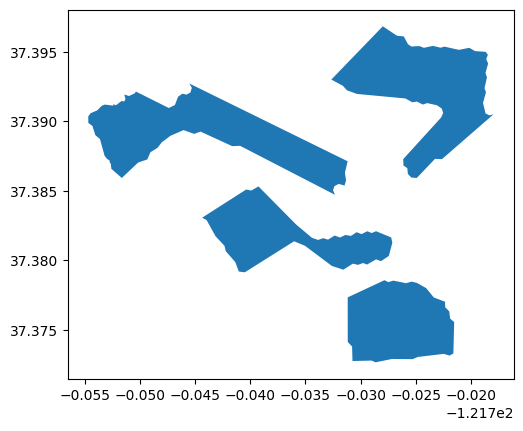

In [12]:
boundary_2020 = preds_2020.dissolve()
boundary_2023 = preds_2023.dissolve()
boundary_2024 = preds_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
# Compute the union of all the reserves
shared_region = pd.concat((boundary_2020, boundary_2023, boundary_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023) > 0:
    shared_region = shared_region.intersection(boundary_2023)
if len(boundary_2024) > 0:
    shared_region = shared_region.intersection(boundary_2024)

shared_region.plot()

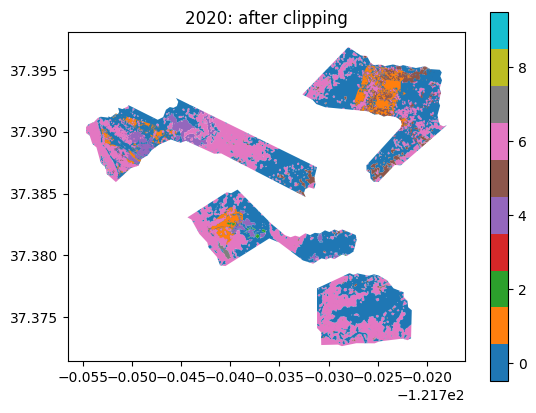

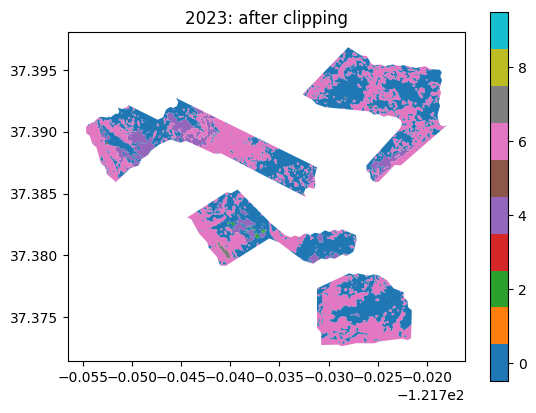

In [13]:
if True:
    standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
    standardized_2023 = compute_standardized(preds_2023, shared_region, reserve=RESERVE, year="2023", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
    standardized_2024 = compute_standardized(preds_2024, shared_region, reserve=RESERVE, year="2024", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
else:
    import geopandas as gpd
    standardized_2020 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2020.gpkg")
    standardized_2023 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2023.gpkg")
    standardized_2024 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2024.gpkg")

Make a table to summarize the class fractions per

In [14]:
final_table = np.zeros((8,3))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy().astype(int), 0] = standardized_2020["area_fraction"]
if standardized_2023 is not None:
    final_table[standardized_2023["class_ID"].to_numpy().astype(int), 1] = standardized_2023["area_fraction"]
if standardized_2024 is not None:
    final_table[standardized_2024["class_ID"].to_numpy().astype(int), 2] = standardized_2024["area_fraction"]

final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023", "2024"],
    index=CLASS_NAMES)
final_table_vis

,2020,2023,2024
Bare Earth,0.533136,4.705317e-01,0.0
Herbaceous Live,0.059870,1.706312e-06,0.0
Man Made,0.001493,1.351684e-03,0.0
Shrub Dead,0.000060,7.891625e-07,0.0
Shrub Live,0.056609,8.543746e-02,0.0
Tree Dead,0.048752,1.639319e-03,0.0
Tree Live,0.418883,4.384811e-01,0.0
Water,0.002401,2.556201e-03,0.0


/ofo-share/repos-david/conda/envs/scientific-python-utils/lib/python3.10/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 18957 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


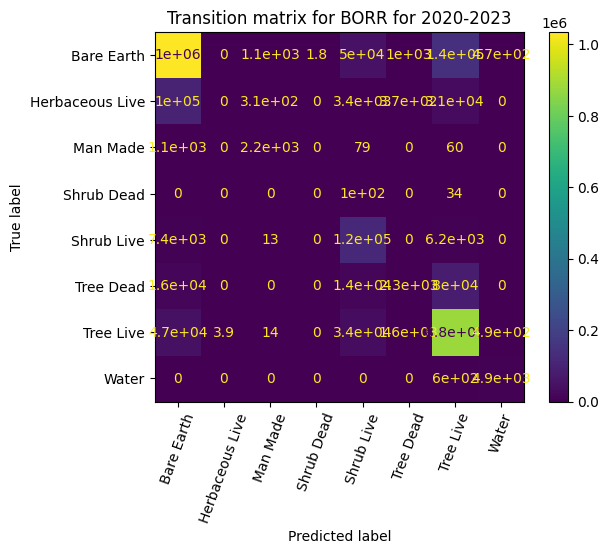

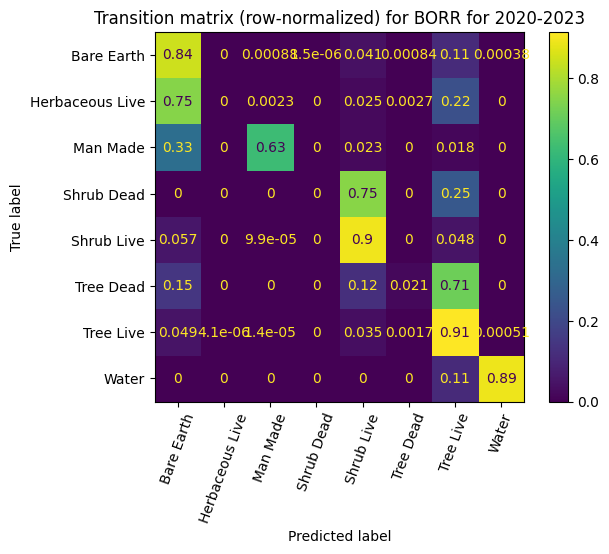

In [15]:
if standardized_2020 is not None and standardized_2023 is not None:
    compute_transition_matrix(standardized_2020, standardized_2023, reserve=RESERVE)

if standardized_2020 is not None and standardized_2024 is not None:
    compute_transition_matrix(standardized_2020, standardized_2024, reserve=RESERVE)

if standardized_2023 is not None and standardized_2024 is not None:
    compute_transition_matrix(standardized_2023, standardized_2024, reserve=RESERVE)

# Merged 2023-2024

This section repeats the last few steps of the last section but after merging the 2023 and 2024 years since they both occured after significant regrowth

<Axes: >

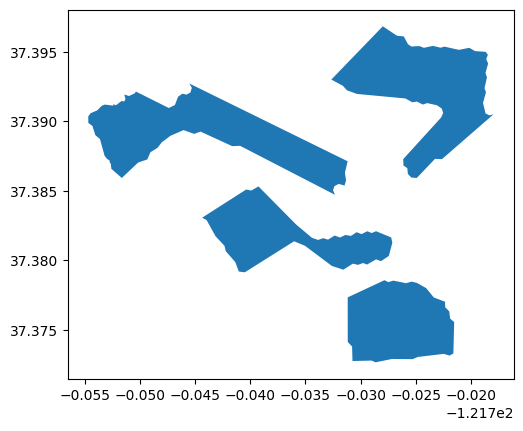

In [16]:
preds_2023_2024 = pd.concat([preds_2023, preds_2024])

boundary_2020 = preds_2020.dissolve()
boundary_2023_2024 = preds_2023_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
# Compute the union of all the reserves
shared_region = pd.concat((boundary_2020, boundary_2023_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023_2024) > 0:
    shared_region = shared_region.intersection(boundary_2023_2024)

shared_region.plot()

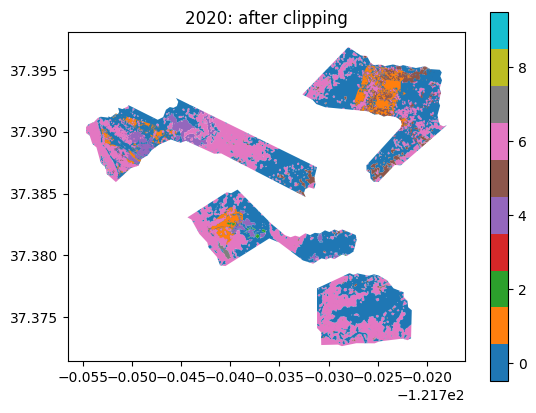

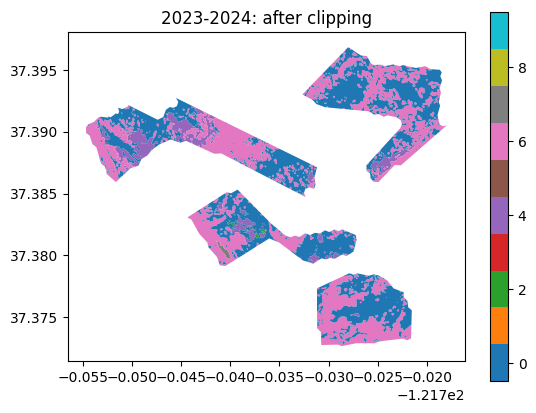

In [17]:
standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
standardized_2023_2024 = compute_standardized(preds_2023_2024, shared_region, reserve=RESERVE, year="2023-2024", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)

In [18]:
final_table = np.zeros((8,2))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy().astype(int), 0] = standardized_2020["area_fraction"]
if standardized_2023_2024 is not None:
    final_table[standardized_2023_2024["class_ID"].to_numpy().astype(int), 1] = standardized_2023_2024["area_fraction"]

final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023-2024"],
    index=CLASS_NAMES)
final_table_vis

,2020,2023-2024
Bare Earth,0.533136,4.705317e-01
Herbaceous Live,0.059870,1.706312e-06
Man Made,0.001493,1.351684e-03
Shrub Dead,0.000060,7.891625e-07
Shrub Live,0.056609,8.543746e-02
Tree Dead,0.048752,1.639319e-03
Tree Live,0.418883,4.384811e-01
Water,0.002401,2.556201e-03


/ofo-share/repos-david/conda/envs/scientific-python-utils/lib/python3.10/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 18957 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


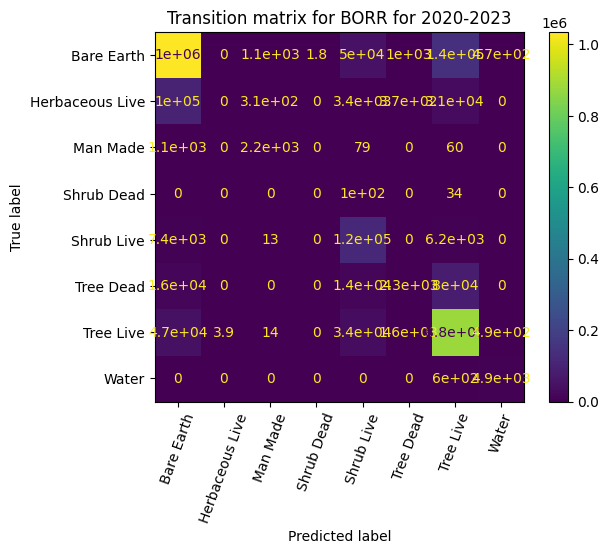

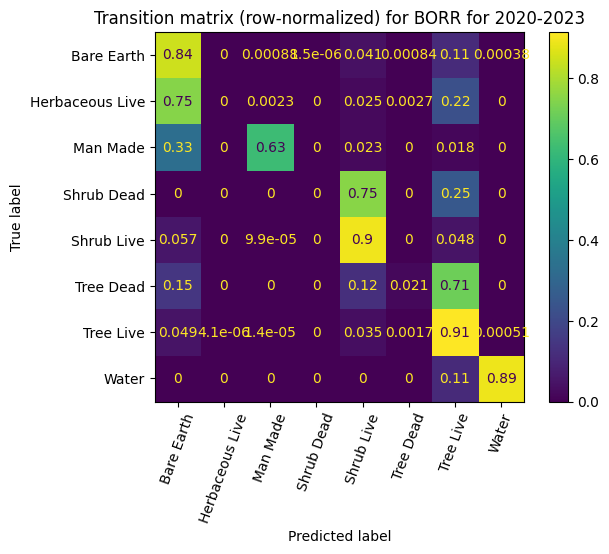

In [ ]:
if standardized_2020 is not None and standardized_2023_2024 is not None:
    compute_transition_matrix(standardized_2020, standardized_2023_2024, reserve=RESERVE)